In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score

from sklearn import model_selection
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

In [2]:
import sklearn

In [3]:
pd.set_option('display.max_columns',None)

## Import cleaned dataset
### Simple model using just Abn% + demographics

In [35]:
pos_final_test = pd.read_csv('./pos_final_test.csv.gz', compression='gzip')

model_cols = pos_final_test.columns.str.contains('mean') | pos_final_test.columns.str.contains('below') | pos_final_test.columns.str.contains('above') | pos_final_test.columns.str.contains('abn') | pos_final_test.columns.isin(['gender', 'age','ethnicity_AMERICAN INDIAN/ALASKA NATIVE', 'ethnicity_ASIAN','ethnicity_BLACK/AFRICAN AMERICAN', 'ethnicity_HISPANIC/LATINO','ethnicity_OTHER', 'ethnicity_UNKNOWN'])
hadm_features = pos_final_test.loc[:, model_cols]
hadm_target = pos_final_test.loc[:, 'pos']

In [5]:
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# hadm_features['ethnicity'] = le.fit_transform(hadm_features['ethnicity'])
# hadm_features['gender'] = le.fit_transform(hadm_features['gender'])

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# hadm_features['age'] = scaler.fit_transform(hadm_features['age'].values.reshape(-1, 1))

## Train test split

In [37]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(hadm_features, hadm_target, test_size=.2, stratify=hadm_target, random_state=25)

In [38]:
# Over and under sample the train set
sm = SMOTE()
X_res_over, y_res_over = sm.fit_resample(X_train, y_train)

nm = NearMiss()
X_res_under, y_res_under = nm.fit_resample(X_train, y_train)

In [39]:
# check target counts
print('Target=0: ',hadm_target[hadm_target==0].count())
print('Target=1: ',hadm_target[hadm_target==1].count())

Target=0:  7359
Target=1:  1198


In [40]:
def results(model):
    '''
    Function to report on the metrics of a GridSearch model.
    Input: GridSearchCV model
    Prints: CV score, best parameters, accuracy, precision, recall, F1, confusion matrix and ROCAUC
    '''
    
#     cross validation scores
    print("Cross Validation")
    print("-" * 20)
    print("Best parameter: ", model.best_params_)
    print("Best CV score:  %.4f" % model.best_score_)

#     confusion matrix & related scores
    pred = model.best_estimator_.predict(X_test)
    print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
    print("_______________________________________________")
    print("Classification Report:", end='')
    print(f"\tPrecision Score: {precision_score(y_test, pred) * 100:.2f}%")
    print(f"\t\t\tRecall Score: {recall_score(y_test, pred) * 100:.2f}%")
    print(f"\t\t\tF1 score: {f1_score(y_test, pred) * 100:.2f}%")
    print("_______________________________________________")
    print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")
    
    svc_disp = plot_roc_curve(model, X_test, y_test)
    plt.show()
    
    if model.estimator.__class__== sklearn.linear_model._logistic.LogisticRegression:
        est_coefs = pd.Series(model.best_estimator_.coef_[0], index=X_train.columns)
        sortedCoefs = np.abs(est_coefs).sort_values(ascending=False)
        print(sortedCoefs[sortedCoefs > 0].head(50))

        
    else:
        est_coefs = pd.Series(model.best_estimator_.feature_importances_, index=X_train.columns)
        sortedCoefs = est_coefs.sort_values(ascending=False)
        print(sortedCoefs.head(50))

## Logistic Regression

### Basic

Cross Validation
--------------------
Best parameter:  {'C': 1}
Best CV score:  0.7737
Accuracy Score: 77.04%
_______________________________________________
Classification Report:	Precision Score: 34.79%
			Recall Score: 72.92%
			F1 score: 47.11%
_______________________________________________
Confusion Matrix: 
 [[1144  328]
 [  65  175]]



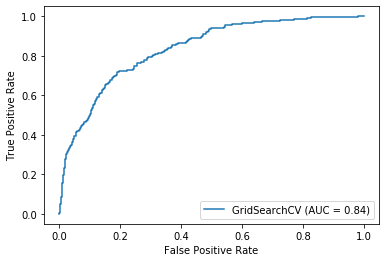

('mean', 51221)                     1.191656
('mean', 51222)                     0.946679
age                                 0.848774
('below_min', 51222)                0.530903
('mean', 50902)                     0.484452
('below_min', 51006)                0.430998
gender                              0.327444
ethnicity_BLACK/AFRICAN AMERICAN    0.291988
('mean', 50983)                     0.283195
('above_max', 50912)                0.282445
('abn_percent', 51006)              0.270333
('abn_percent', 50912)              0.255827
('mean', 51006)                     0.215187
('abn_percent', 51222)              0.212164
ethnicity_ASIAN                     0.185499
ethnicity_OTHER                     0.181026
('mean', 50912)                     0.174216
('abn_percent', 51221)              0.164523
('abn_percent', 50971)              0.154688
ethnicity_HISPANIC/LATINO           0.144011
('abn_percent', 50868)              0.136784
('mean', 51265)                     0.118362
('above_ma

In [41]:
%%time

params ={'C':range(1, 1000, 300)}
logReg = LogisticRegression(penalty = 'l1', max_iter = 2000, class_weight = "balanced", solver = 'liblinear')

grid_log = GridSearchCV(estimator = logReg, param_grid = params, cv = 3)
grid_log.fit(X_train, y_train)
grid_log.best_score_

results(grid_log)

### Over Sampling using SMOTE

In [42]:
%%time
params ={'C':range(1, 1000, 300)}
logReg = LogisticRegression(penalty = 'l1', max_iter = 2000, class_weight = "balanced", solver = 'liblinear')

grid_log_over = GridSearchCV(estimator = logReg, param_grid = params, cv = 3)
grid_log_over.fit(X_res_over, y_res_over)

CPU times: user 9.45 s, sys: 906 ms, total: 10.4 s
Wall time: 4.24 s


GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=2000, penalty='l1',
                                          solver='liblinear'),
             param_grid={'C': range(1, 1000, 300)})

Cross Validation
--------------------
Best parameter:  {'C': 901}
Best CV score:  0.7932
Accuracy Score: 76.46%
_______________________________________________
Classification Report:	Precision Score: 32.77%
			Recall Score: 64.58%
			F1 score: 43.48%
_______________________________________________
Confusion Matrix: 
 [[1154  318]
 [  85  155]]



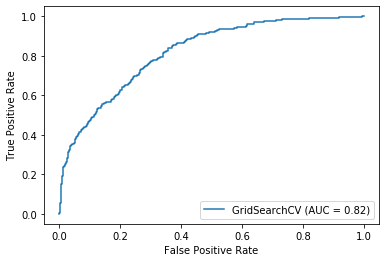

ethnicity_ASIAN                            2.310119
ethnicity_OTHER                            2.038398
ethnicity_AMERICAN INDIAN/ALASKA NATIVE    1.948794
ethnicity_HISPANIC/LATINO                  1.791982
ethnicity_UNKNOWN                          1.736987
('mean', 51221)                            1.604947
('mean', 51222)                            1.221305
ethnicity_BLACK/AFRICAN AMERICAN           1.125659
age                                        0.856012
('below_min', 51222)                       0.801640
('below_min', 51006)                       0.581301
gender                                     0.550102
('above_max', 50912)                       0.529239
('mean', 50902)                            0.498454
('mean', 50912)                            0.427004
('mean', 50983)                            0.328001
('abn_percent', 51222)                     0.275783
('abn_percent', 50912)                     0.268903
('abn_percent', 50971)                     0.233695
('abn_percen

In [43]:
results(grid_log_over)

### Under Sampling using Near Miss

In [44]:
%%time
params ={'C':range(1, 1000, 300)}
logReg = LogisticRegression(penalty = 'l1', max_iter = 2000, class_weight = "balanced", solver = 'liblinear')

grid_log_under = GridSearchCV(estimator = logReg, param_grid = params, cv = 3)
grid_log_under.fit(X_res_under, y_res_under)
grid_log_under.best_score_

CPU times: user 3.86 s, sys: 557 ms, total: 4.42 s
Wall time: 777 ms


0.9044704778070489

Cross Validation
--------------------
Best parameter:  {'C': 1}
Best CV score:  0.9045
Accuracy Score: 54.15%
_______________________________________________
Classification Report:	Precision Score: 21.29%
			Recall Score: 84.17%
			F1 score: 33.98%
_______________________________________________
Confusion Matrix: 
 [[725 747]
 [ 38 202]]



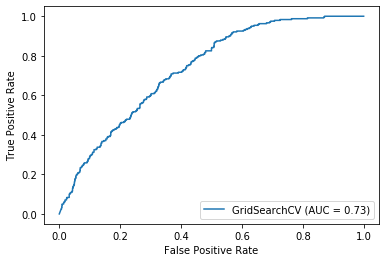

('abn_percent', 50882)              1.744138
('abn_percent', 50983)              1.674417
('above_max', 50931)                1.672770
('abn_percent', 50971)              1.309224
('below_min', 50931)                1.268013
('below_min', 50971)                1.084622
('abn_percent', 50902)              1.067479
ethnicity_BLACK/AFRICAN AMERICAN    1.034069
('below_min', 50868)                1.003075
('abn_percent', 50868)              0.967383
ethnicity_ASIAN                     0.871244
age                                 0.845972
('abn_percent', 51265)              0.827988
('mean', 51222)                     0.809280
('mean', 51221)                     0.796535
('below_min', 50902)                0.714823
('above_max', 50882)                0.680272
('abn_percent', 51006)              0.568834
('mean', 50902)                     0.500918
ethnicity_UNKNOWN                   0.485745
('mean', 50912)                     0.481866
ethnicity_HISPANIC/LATINO           0.447179
('above_ma

In [45]:
results(grid_log_under)

## Random Forest

### Basic

In [46]:
%%time
param_grid={'criterion': ['entropy','gini'],
            'n_estimators': range(1,500,50),
            'max_depth': range(10,110,20)
            }

grid_rf = model_selection.GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, cv=3)
grid_rf.fit(X_train, y_train)

CPU times: user 8min 31s, sys: 4.82 s, total: 8min 36s
Wall time: 8min 38s


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(10, 110, 20),
                         'n_estimators': range(1, 500, 50)})

Cross Validation
--------------------
Best parameter:  {'criterion': 'entropy', 'max_depth': 50, 'n_estimators': 251}
Best CV score:  0.8717
Accuracy Score: 87.73%
_______________________________________________
Classification Report:	Precision Score: 67.05%
			Recall Score: 24.58%
			F1 score: 35.98%
_______________________________________________
Confusion Matrix: 
 [[1443   29]
 [ 181   59]]



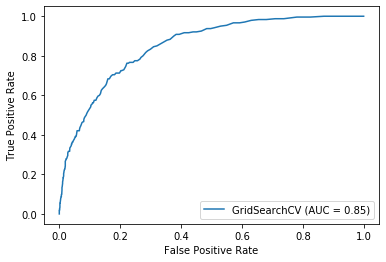

('mean', 51006)                     0.072989
age                                 0.070188
('above_max', 51006)                0.066914
('mean', 50912)                     0.050845
('mean', 50902)                     0.040909
('mean', 50882)                     0.040051
('mean', 51222)                     0.037574
('above_max', 50931)                0.037479
('mean', 50868)                     0.036105
('mean', 50931)                     0.036048
('mean', 51221)                     0.036028
('mean', 51265)                     0.035308
('mean', 50971)                     0.034816
('mean', 50983)                     0.034771
('abn_percent', 51006)              0.032939
('above_max', 50912)                0.031088
('below_min', 51221)                0.028445
('below_min', 51222)                0.027781
('abn_percent', 50912)              0.021949
('abn_percent', 50931)              0.020261
('abn_percent', 50882)              0.016434
('below_min', 51265)                0.013419
('abn_perc

In [47]:
results(grid_rf)

### Over Sampling using SMOTE

In [48]:
%%time
param_grid={'criterion': ['gini'],
            'n_estimators': range(1,500,50),
            'max_depth': range(10,50,20)
            }

grid_rf_over = model_selection.GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, cv=3)
grid_rf_over.fit(X_res_over, y_res_over)

CPU times: user 4min 27s, sys: 2.68 s, total: 4min 30s
Wall time: 4min 31s


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini'], 'max_depth': range(10, 50, 20),
                         'n_estimators': range(1, 500, 50)})

Cross Validation
--------------------
Best parameter:  {'criterion': 'gini', 'max_depth': 30, 'n_estimators': 151}
Best CV score:  0.9185
Accuracy Score: 84.87%
_______________________________________________
Classification Report:	Precision Score: 46.33%
			Recall Score: 50.00%
			F1 score: 48.10%
_______________________________________________
Confusion Matrix: 
 [[1333  139]
 [ 120  120]]



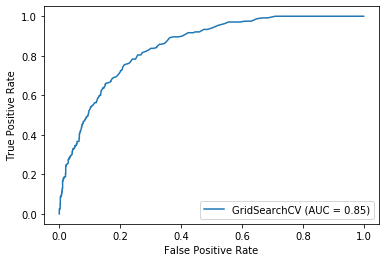

('above_max', 51006)                0.083178
age                                 0.077643
('mean', 51006)                     0.077283
('abn_percent', 51006)              0.060037
('above_max', 50912)                0.058489
('abn_percent', 50912)              0.041776
('mean', 50912)                     0.040557
('above_max', 50931)                0.034610
('abn_percent', 50931)              0.030751
('mean', 50868)                     0.030316
('mean', 50882)                     0.029025
('mean', 50902)                     0.027996
('mean', 50983)                     0.026444
('mean', 50971)                     0.026267
('mean', 50931)                     0.024971
('mean', 51222)                     0.024035
('mean', 51221)                     0.023483
('mean', 51265)                     0.022718
('below_min', 51222)                0.021791
('below_min', 51221)                0.020665
('abn_percent', 50882)              0.019855
gender                              0.017869
('abn_perc

In [49]:
results(grid_rf_over)

### Under Sampling using Near Miss

In [50]:
%%time
param_grid={'criterion': ['gini'],
            'n_estimators': range(1,501,50),
            'max_depth': range(10,50,20)
            }

grid_rf_under = model_selection.GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, cv=3)
grid_rf_under.fit(X_res_under, y_res_under)

CPU times: user 58.4 s, sys: 716 ms, total: 59.1 s
Wall time: 59.7 s


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini'], 'max_depth': range(10, 50, 20),
                         'n_estimators': range(1, 501, 50)})

Cross Validation
--------------------
Best parameter:  {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 201}
Best CV score:  0.8987
Accuracy Score: 52.75%
_______________________________________________
Classification Report:	Precision Score: 21.00%
			Recall Score: 85.83%
			F1 score: 33.74%
_______________________________________________
Confusion Matrix: 
 [[697 775]
 [ 34 206]]



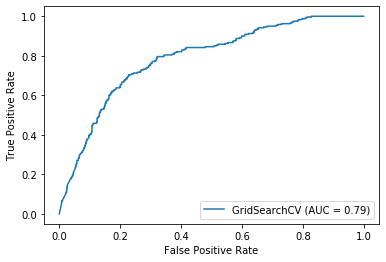

('abn_percent', 51006)              0.138253
('above_max', 51006)                0.117070
('mean', 51006)                     0.085028
('abn_percent', 50882)              0.070808
('abn_percent', 50912)              0.057536
('above_max', 50912)                0.048326
('above_max', 50931)                0.040578
('mean', 50912)                     0.034591
('abn_percent', 50902)              0.031792
('abn_percent', 50971)              0.030354
('abn_percent', 51265)              0.027684
('below_min', 51222)                0.023669
('mean', 51222)                     0.022855
('mean', 50902)                     0.020497
age                                 0.016792
('abn_percent', 50983)              0.016607
('mean', 51265)                     0.016247
('below_min', 50902)                0.016065
('below_min', 50882)                0.015880
('mean', 50983)                     0.015483
('mean', 50931)                     0.014924
('mean', 50882)                     0.013856
('mean', 5

In [51]:
results(grid_rf_under)

## Gradient Boost

In [52]:
# additive approach using 1. n_estimators 2. max_depth, min_samples
# perhaps use randomsearch instead of gridsearch
# look at area under curve (AUC)

### basic

In [53]:
%%time
param_grid={'n_estimators':range(85,110,5),
            }

grid_gb = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, cv=3)
grid_gb.fit(X_train, y_train)

CPU times: user 44.4 s, sys: 483 ms, total: 44.9 s
Wall time: 45.4 s


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'n_estimators': range(85, 110, 5)})

Cross Validation
--------------------
Best parameter:  {'n_estimators': 105}
Best CV score:  0.8722
Accuracy Score: 87.56%
_______________________________________________
Classification Report:	Precision Score: 63.11%
			Recall Score: 27.08%
			F1 score: 37.90%
_______________________________________________
Confusion Matrix: 
 [[1434   38]
 [ 175   65]]



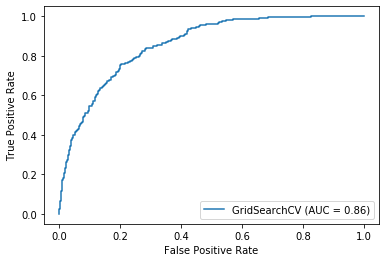

('above_max', 51006)                       0.334659
age                                        0.094534
('mean', 51006)                            0.086930
('mean', 50902)                            0.063805
('mean', 50912)                            0.045881
('mean', 50882)                            0.044788
('above_max', 50912)                       0.039451
('mean', 50868)                            0.034079
('above_max', 50882)                       0.033839
('mean', 51222)                            0.029672
('mean', 51221)                            0.023952
('above_max', 50931)                       0.022396
('mean', 50983)                            0.021837
('mean', 50971)                            0.013692
('mean', 51265)                            0.012137
('below_min', 51221)                       0.009625
('mean', 50931)                            0.006892
('abn_percent', 50983)                     0.006636
('abn_percent', 51221)                     0.006188
('below_min'

In [54]:
results(grid_gb)

In [55]:
%%time
param_grid={'n_estimators':[95],
            'max_depth':range(1,8,2),
            'min_samples_split':range(2,8,2),
            'max_features':range(10,15,2),
            }

grid_gb = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, cv=3)
grid_gb.fit(X_train, y_train)


CPU times: user 2min 5s, sys: 1.52 s, total: 2min 7s
Wall time: 2min 8s


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': range(1, 8, 2),
                         'max_features': range(10, 15, 2),
                         'min_samples_split': range(2, 8, 2),
                         'n_estimators': [95]})

Cross Validation
--------------------
Best parameter:  {'max_depth': 3, 'max_features': 10, 'min_samples_split': 4, 'n_estimators': 95}
Best CV score:  0.8723
Accuracy Score: 87.44%
_______________________________________________
Classification Report:	Precision Score: 62.14%
			Recall Score: 26.67%
			F1 score: 37.32%
_______________________________________________
Confusion Matrix: 
 [[1433   39]
 [ 176   64]]



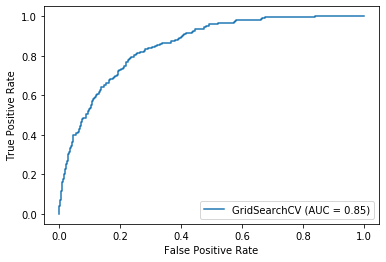

('above_max', 51006)                       0.190762
('mean', 51006)                            0.123741
age                                        0.107181
('mean', 50912)                            0.088925
('above_max', 50912)                       0.063003
('mean', 50902)                            0.050014
('above_max', 50931)                       0.035992
('above_max', 50882)                       0.033895
('mean', 50882)                            0.029836
('mean', 51222)                            0.025813
('abn_percent', 51006)                     0.023980
('mean', 50868)                            0.023008
('below_min', 50902)                       0.019735
('mean', 50983)                            0.018880
('abn_percent', 50912)                     0.015629
('mean', 50971)                            0.011955
('mean', 51265)                            0.011890
('above_max', 50902)                       0.011335
('below_min', 51222)                       0.009985
('mean', 509

In [56]:
results(grid_gb)

### Over Sampling using SMOTE¶

In [57]:
%%time
param_grid={'n_estimators':range(120,161,10),
            'max_depth':range(10,13,1),
            }

grid_gb_over = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, cv=3)
grid_gb_over.fit(X_res_over, y_res_over)

CPU times: user 20min 49s, sys: 5.28 s, total: 20min 54s
Wall time: 21min


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': range(10, 13),
                         'n_estimators': range(120, 161, 10)})

Cross Validation
--------------------
Best parameter:  {'max_depth': 12, 'n_estimators': 160}
Best CV score:  0.9234
Accuracy Score: 86.45%
_______________________________________________
Classification Report:	Precision Score: 52.20%
			Recall Score: 39.58%
			F1 score: 45.02%
_______________________________________________
Confusion Matrix: 
 [[1385   87]
 [ 145   95]]



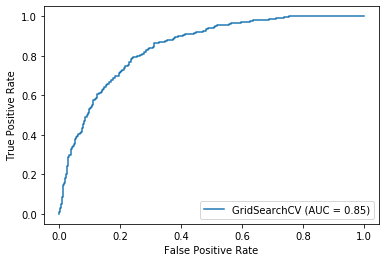

('above_max', 51006)                0.333057
age                                 0.082902
('above_max', 50912)                0.053226
('mean', 50868)                     0.039994
('above_max', 50931)                0.028881
('mean', 50902)                     0.028004
('mean', 51006)                     0.027873
('mean', 50882)                     0.027435
('mean', 50983)                     0.027344
('mean', 50971)                     0.024681
('mean', 50931)                     0.024597
('mean', 50912)                     0.022830
('mean', 51222)                     0.022064
('mean', 51265)                     0.020837
('above_max', 50882)                0.020413
gender                              0.018858
('mean', 51221)                     0.017552
('abn_percent', 50931)              0.017003
('below_min', 51222)                0.014056
('below_min', 51221)                0.012509
('abn_percent', 51221)              0.009362
('abn_percent', 50902)              0.008541
('abn_perc

In [58]:
results(grid_gb_over)

Cross Validation
--------------------
Best parameter:  {'max_depth': 13, 'max_features': 12, 'min_samples_split': 20, 'n_estimators': 80}
Best CV score:  0.9238
Accuracy Score: 86.21%
_______________________________________________
Classification Report:	Precision Score: 50.98%
			Recall Score: 43.33%
			F1 score: 46.85%
_______________________________________________
Confusion Matrix: 
 [[1372  100]
 [ 136  104]]



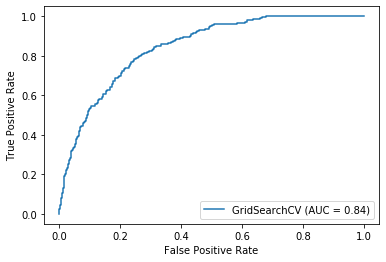

('above_max', 51006)                0.163931
age                                 0.081696
('mean', 51006)                     0.079027
('abn_percent', 50912)              0.047406
('abn_percent', 51006)              0.046917
('above_max', 50912)                0.043345
('mean', 50912)                     0.038582
('mean', 50868)                     0.033777
('abn_percent', 50931)              0.029625
('mean', 50902)                     0.028276
('mean', 50882)                     0.027050
('mean', 50983)                     0.026328
('mean', 50971)                     0.025442
('above_max', 50931)                0.025097
('mean', 51222)                     0.021520
gender                              0.021462
('mean', 51221)                     0.021115
('mean', 50931)                     0.020608
('mean', 51265)                     0.019576
('below_min', 51222)                0.016080
('below_min', 51221)                0.016011
('above_max', 50882)                0.012027
('abn_perc

In [59]:
%%time
param_grid={'n_estimators':range(20,81,20),
            'max_depth':range(5,16,4),
            'min_samples_split':range(20,100,30),
            'max_features':range(7,20,5),
            }
# 'max_depth': 9, 'n_estimators': 80
grid_gb_over = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, cv=3)
grid_gb_over.fit(X_res_over, y_res_over)

results(grid_gb_over)

### Under Sampling using Near Miss

Cross Validation
--------------------
Best parameter:  {'n_estimators': 80}
Best CV score:  0.8992
Accuracy Score: 54.56%
_______________________________________________
Classification Report:	Precision Score: 21.98%
			Recall Score: 87.92%
			F1 score: 35.17%
_______________________________________________
Confusion Matrix: 
 [[723 749]
 [ 29 211]]



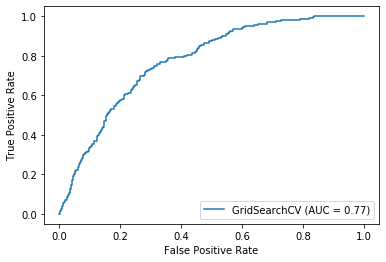

('abn_percent', 51006)                     0.469681
('above_max', 51006)                       0.095886
('abn_percent', 50882)                     0.093852
('abn_percent', 51265)                     0.047301
('abn_percent', 50983)                     0.026952
('abn_percent', 50971)                     0.025580
('mean', 50902)                            0.024422
('abn_percent', 50912)                     0.024323
('mean', 51006)                            0.024006
('abn_percent', 50902)                     0.022050
age                                        0.021381
('above_max', 50931)                       0.021103
('mean', 51222)                            0.018391
('mean', 50931)                            0.016168
('mean', 50868)                            0.011872
('mean', 50983)                            0.010302
('abn_percent', 50868)                     0.008396
('mean', 51221)                            0.006996
('mean', 50912)                            0.006640
('mean', 512

In [60]:
%%time
param_grid={'n_estimators':range(20,100,10),
            }

grid_gb_under = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, cv=3)
grid_gb_under.fit(X_res_under, y_res_under)

results(grid_gb_under)

Cross Validation
--------------------
Best parameter:  {'max_depth': 5, 'max_features': 12, 'min_samples_split': 20, 'n_estimators': 50}
Best CV score:  0.9066
Accuracy Score: 52.39%
_______________________________________________
Classification Report:	Precision Score: 20.93%
			Recall Score: 86.25%
			F1 score: 33.69%
_______________________________________________
Confusion Matrix: 
 [[690 782]
 [ 33 207]]



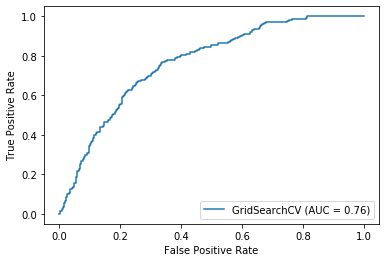

('abn_percent', 50882)                     0.166235
('above_max', 51006)                       0.163409
('abn_percent', 51006)                     0.101830
('abn_percent', 50912)                     0.088291
('mean', 51006)                            0.087226
('abn_percent', 51265)                     0.041278
('abn_percent', 50971)                     0.038475
('abn_percent', 50902)                     0.029163
('mean', 50912)                            0.027028
age                                        0.025812
('mean', 50931)                            0.023439
('mean', 51222)                            0.019540
('mean', 50902)                            0.019031
('above_max', 50931)                       0.019005
('abn_percent', 50983)                     0.015510
('abn_percent', 50868)                     0.015016
('mean', 50983)                            0.014414
('above_max', 50912)                       0.012391
('mean', 50868)                            0.011623
('below_min'

In [61]:
param_grid={'n_estimators':range(50,51,1),
            'max_depth':range(5,16,4),
            'min_samples_split':range(20,100,30),
            'max_features':range(7,20,5),
            }

grid_gb_under = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, cv=3)
grid_gb_under.fit(X_res_under, y_res_under)

results(grid_gb_under)


## Gather Metrics

In [62]:
def gather_metrics(model_list):
    '''
    Gathers metrics from models in model_list and returns a dataframe of gathered metrics.
    '''
    metrics = pd.DataFrame(columns = ['Model','Sampling','F1','ROC_AUC','Recall','Accuracy','Precision'])
    sampling_types = ['None','Under Sample','Over Sample']
    counter=0
    
    for model in model_list:
        pred = model.best_estimator_.predict(X_test)
        
        f1 = f1_score(y_test, pred)
        roc_auc = roc_auc_score(y_test, pred)
        recall = recall_score(y_test, pred)
        accuracy = accuracy_score(y_test, pred)
        precision = precision_score(y_test, pred)
        
        model_name = type(model.estimator).__name__
        sampling = sampling_types[counter%3]
        counter += 1
        
        metrics = metrics.append({'Model':model_name,
                                  "Sampling":sampling,
                                  'F1':f1,
                                  'ROC_AUC':roc_auc,
                                  'Recall':recall,
                                  'Accuracy':accuracy,
                                  'Precision':precision}
                                 ,ignore_index=True)        
    return metrics

In [63]:
model_list=[grid_log, grid_log_under, grid_log_over,
            grid_gb, grid_gb_under, grid_gb_over,
            grid_rf, grid_rf_under, grid_rf_over
           ]
gather_metrics(model_list)

,Model,Sampling,F1,ROC_AUC,Recall,Accuracy,Precision
0,LogisticRegression,None,0.471063,0.753170,0.729167,0.770444,0.347913
1,LogisticRegression,Under Sample,0.339781,0.667097,0.841667,0.541472,0.212856
2,LogisticRegression,Over Sample,0.434783,0.714900,0.645833,0.764603,0.327696
3,GradientBoostingClassifier,None,0.373178,0.620086,0.266667,0.874416,0.621359
4,GradientBoostingClassifier,Under Sample,0.336859,0.665625,0.862500,0.523949,0.209302
5,GradientBoostingClassifier,Over Sample,0.468468,0.682699,0.433333,0.862150,0.509804
6,RandomForestClassifier,None,0.359756,0.613066,0.245833,0.877336,0.670455
7,RandomForestClassifier,Under Sample,0.337428,0.665919,0.858333,0.527453,0.209990
8,RandomForestClassifier,Over Sample,0.480962,0.702785,0.500000,0.848715,0.463320


## Gather Best Features

In [64]:
def gather_best_features(model_list):
    best_features = pd.DataFrame()
    sampling_types = ['None','Under Sample','Over Sample']
    
    counter=0
    for model in model_list:
        if model.estimator.__class__== sklearn.linear_model._logistic.LogisticRegression:
            est_coefs = pd.Series(grid_log.best_estimator_.coef_[0], index=X_train.columns)
        else:
            est_coefs = pd.Series(model.best_estimator_.feature_importances_, index=X_train.columns)
            
        sortedCoefs = np.abs(est_coefs).sort_values(ascending=False)

        model_name = type(model.estimator).__name__
        sampling = sampling_types[counter%3]
        model_string = model_name+sampling
        counter += 1

        sorted_df = pd.DataFrame(sortedCoefs).reset_index().rename(columns={"index":'features', 0: model_string})
        best_features = pd.concat([best_features, sorted_df], axis=1)
    return best_features

In [65]:
gather_best_features(model_list)

,features,LogisticRegressionNone,features,LogisticRegressionUnder Sample,features,LogisticRegressionOver Sample,features,GradientBoostingClassifierNone,features,GradientBoostingClassifierUnder Sample,features,GradientBoostingClassifierOver Sample,features,RandomForestClassifierNone,features,RandomForestClassifierUnder Sample,features,RandomForestClassifierOver Sample
0,"('mean', 51221)",1.191656,"('mean', 51221)",1.191656,"('mean', 51221)",1.191656,"('above_max', 51006)",0.190762,"('abn_percent', 50882)",0.166235,"('above_max', 51006)",0.163931,"('mean', 51006)",0.072989,"('abn_percent', 51006)",0.138253,"('above_max', 51006)",0.083178
1,"('mean', 51222)",0.946679,"('mean', 51222)",0.946679,"('mean', 51222)",0.946679,"('mean', 51006)",0.123741,"('above_max', 51006)",0.163409,age,0.081696,age,0.070188,"('above_max', 51006)",0.117070,age,0.077643
2,age,0.848774,age,0.848774,age,0.848774,age,0.107181,"('abn_percent', 51006)",0.101830,"('mean', 51006)",0.079027,"('above_max', 51006)",0.066914,"('mean', 51006)",0.085028,"('mean', 51006)",0.077283
3,"('below_min', 51222)",0.530903,"('below_min', 51222)",0.530903,"('below_min', 51222)",0.530903,"('mean', 50912)",0.088925,"('abn_percent', 50912)",0.088291,"('abn_percent', 50912)",0.047406,"('mean', 50912)",0.050845,"('abn_percent', 50882)",0.070808,"('abn_percent', 51006)",0.060037
4,"('mean', 50902)",0.484452,"('mean', 50902)",0.484452,"('mean', 50902)",0.484452,"('above_max', 50912)",0.063003,"('mean', 51006)",0.087226,"('abn_percent', 51006)",0.046917,"('mean', 50902)",0.040909,"('abn_percent', 50912)",0.057536,"('above_max', 50912)",0.058489
5,"('below_min', 51006)",0.430998,"('below_min', 51006)",0.430998,"('below_min', 51006)",0.430998,"('mean', 50902)",0.050014,"('abn_percent', 51265)",0.041278,"('above_max', 50912)",0.043345,"('mean', 50882)",0.040051,"('above_max', 50912)",0.048326,"('abn_percent', 50912)",0.041776
6,gender,0.327444,gender,0.327444,gender,0.327444,"('above_max', 50931)",0.035992,"('abn_percent', 50971)",0.038475,"('mean', 50912)",0.038582,"('mean', 51222)",0.037574,"('above_max', 50931)",0.040578,"('mean', 50912)",0.040557
7,ethnicity_BLACK/AFRICAN AMERICAN,0.291988,ethnicity_BLACK/AFRICAN AMERICAN,0.291988,ethnicity_BLACK/AFRICAN AMERICAN,0.291988,"('above_max', 50882)",0.033895,"('abn_percent', 50902)",0.029163,"('mean', 50868)",0.033777,"('above_max', 50931)",0.037479,"('mean', 50912)",0.034591,"('above_max', 50931)",0.034610
8,"('mean', 50983)",0.283195,"('mean', 50983)",0.283195,"('mean', 50983)",0.283195,"('mean', 50882)",0.029836,"('mean', 50912)",0.027028,"('abn_percent', 50931)",0.029625,"('mean', 50868)",0.036105,"('abn_percent', 50902)",0.031792,"('abn_percent', 50931)",0.030751
9,"('above_max', 50912)",0.282445,"('above_max', 50912)",0.282445,"('above_max', 50912)",0.282445,"('mean', 51222)",0.025813,age,0.025812,"('mean', 50902)",0.028276,"('mean', 50931)",0.036048,"('abn_percent', 50971)",0.030354,"('mean', 50868)",0.030316
